__Objetivo__ deste produto é fornecer um serviço automatizado que recomenda leads para um usuário dado sua atual lista de clientes (Portfólio).

Para a apresentação do projeto, o tempo entre o treinamento do modelo e o output deve ser menor que 20 min.

__Link__: https://codenation.dev/private-journey/ds-online-1/challenge/ml-leads

__Dicionário dos dados__: https://s3-us-west-1.amazonaws.com/codenation-challenges/ml-leads/features_dictionary.pdf

Algumas empresas gostariam de saber quem são as demais empresas em um determinado mercado (população) que tem maior probabilidade se tornarem seus próximos clientes. Ou seja, a sua solução deve encontrar no mercado quem são os leads mais aderentes dado as características dos clientes presentes no portfólio do usuário.

* Mercado: Base com informações sobre as empresas do Mercado a ser considerado. 
* Portfolio 1: Ids dos clientes da empresa 1 
* Portfolio 2: Ids dos clientes da empresa 2 
* Portfolio 3: Ids dos clientes da empresa 3

__Obs__: todas as empresas(ids) dos portfolios estão contidos no Mercado(base de população).

__Data Entrega__: 15/06/2020

__Referência para apresentação__: https://docs.google.com/document/d/1novCIxrYgVUopk_zRr2ervx9CukoI600RDOhX6MMU2I/edit

In [1]:
# importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import funcoes as func
import pickle

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

import warnings

warnings.filterwarnings("ignore")

In [2]:
# Definindo set de visualizações
sns.set(style='whitegrid',
        font_scale=1.5)

pd.set_option('display.max_rows', 200)

%matplotlib inline

### Carregando os Dados

In [3]:
mercado = pd.read_csv("./estaticos_market.csv", index_col = 0)
portifolio1 = pd.read_csv("./estaticos_portfolio1.csv", index_col = 0)
portifolio2 = pd.read_csv("./estaticos_portfolio2.csv", index_col = 0)
portifolio3 = pd.read_csv("./estaticos_portfolio3.csv", index_col = 0)

### Análise exploratória

In [4]:
mercado.head()

,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,...,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,INDUSTRIA DA CONSTRUCAO,CONSTRUÇÃO CIVIL,14.457534,10 a 15,False,...,43.738462,93.266667,19.166667,26.0,26.0,27.0,0.0,-3.703704,0.0,0
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,True,EMPRESARIO INDIVIDUAL,PI,OUTROS,SERVICOS DE ALOJAMENTO/ALIMENTACAO,SERVIÇO,1.463014,1 a 5,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,"TRANSPORTE, ARMAZENAGEM E CORREIO",SERVIÇO,7.093151,5 a 10,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,SERVICOS DIVERSOS,SERVIÇO,6.512329,5 a 10,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,True,EMPRESARIO INDIVIDUAL,RN,OUTROS,"SERVICOS PROFISSIONAIS, TECNICOS E CIENTIFICOS",SERVIÇO,3.200000,1 a 5,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [5]:
portifolio1.head()

,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,...,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
0,dabe79bec87c88ae04e869bf6bd321ee5e1893cecf6625...,True,EMPRESARIO INDIVIDUAL,PI,OUTROS,COMERCIO VAREJISTA,COMERCIO,0.646575,<= 1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,32e5f4e10932153a7ba869cb0386e7e02d49d2461046b8...,False,EMPRESARIO INDIVIDUAL,MA,OUTROS,COMERCIO VAREJISTA,COMERCIO,6.586301,5 a 10,False,...,NaN,NaN,NaN,0.0,0.0,2.0,NaN,-100.0,0.0,4
2,a95d6f30bba445bd3d6b0c5b36f865b38ec01d17336090...,True,EMPRESARIO INDIVIDUAL,MA,OUTROS,COMERCIO VAREJISTA,COMERCIO,8.010959,5 a 10,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,6cb309685cea0b6d2988818792ec2e6fcb2bd02e0afa9e...,True,EMPRESARIO INDIVIDUAL,RN,OUTROS,COMERCIO VAREJISTA,COMERCIO,20.863014,> 20,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,f72aa7fa6787b0a5a1c88885b6120850df8ee0f71adc25...,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,COMERCIO VAREJISTA,COMERCIO,18.726027,15 a 20,False,...,39.454762,91.2,19.333333,14.0,15.0,25.0,-6.666667,-44.0,0.0,3


In [6]:
portifolio2.head()

,id
0,09e95c1a84049001d086470a8f320a19b076f955a89122...
1,dc9d155f5bcd3172031e2ec9431786e8871ff4b0ff4728...
2,16843c9ffb920170477118933798510d8d5f00f5c56c12...
3,ff045934d90aab184dd15e66daf3b3c97193bda5449298...
4,a0ce528caab2c62497a548d0ebd9e935143ef81ed7dbf0...


In [7]:
portifolio3.head()

,id
0,bb61c09449a1c1f8b78955d8b7a7f73599e78358993fe2...
1,16843c9ffb920170477118933798510d8d5f00f5c56c12...
2,1b8d092daff12bed8b3c2ab93bf5df2921865a68aca185...
3,3aafa3a1f12f483740a52956af100223333d0e3c79bf2c...
4,c60431fbca90067f105570e1e8a684bcd7048205bbf6c4...


In [8]:
# analisando o tamanho dos dados
print("Dataset do mercado shape = {}".format(mercado.shape))
print("Dataset do portfolio1 shape = {}".format(portifolio1.shape))
print("Dataset do portfolio2 shape = {}".format(portifolio2.shape))
print("Dataset do portfolio3 shape = {}".format(portifolio3.shape))

Dataset do mercado shape = (462298, 181)
Dataset do portfolio1 shape = (555, 181)
Dataset do portfolio2 shape = (566, 1)
Dataset do portfolio3 shape = (265, 1)


In [56]:
# Tem colunas com muitos valores missing. Vou apagar colunas com mais de 10% de valores nan
dataPctMissing = func.ResumeDados(mercado)

colunasMuitoNA = dataPctMissing[dataPctMissing["PorcentagemValorMissing(%)"] >= 10.0].index

dataPctMissing.sort_values(by = "PorcentagemValorMissing(%)", ascending = False)

,Tipo,NumValorMissing,PorcentagemValorMissing(%)
qt_alteracao_socio_365d,float64,462298,100.00
qt_alteracao_socio_90d,float64,462298,100.00
grau_instrucao_macro_desconhecido,float64,462298,100.00
qt_alteracao_socio_total,float64,462298,100.00
qt_alteracao_socio_180d,float64,462298,100.00
idade_media_coligadas_baixadas,float64,462162,99.97
coligada_mais_antiga_baixada,float64,462162,99.97
coligada_mais_nova_baixada,float64,462162,99.97
vl_total_veiculos_antt,float64,462122,99.96
vl_total_tancagem,float64,462018,99.94


In [10]:
mercado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 462298 entries, 0 to 462297
Columns: 181 entries, id to qt_filiais
dtypes: bool(9), float64(144), int64(1), object(27)
memory usage: 614.1+ MB


In [11]:
mercado.describe()

,idade_empresa_anos,vl_total_tancagem,vl_total_veiculos_antt,vl_total_veiculos_leves,vl_total_veiculos_pesados,qt_art,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,vl_total_tancagem_grupo,vl_total_veiculos_antt_grupo,...,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
count,462298.000000,280.000000,176.000000,30684.000000,30684.000000,6590.000000,460371.000000,460371.000000,1760.000000,336.000000,...,76261.000000,76261.000000,76261.000000,103574.000000,103574.000000,103574.000000,73888.000000,74014.000000,103574.000000,462298.000000
mean,9.948677,32.014286,3.818182,2.244329,1.177813,5.769044,3.591801,48.699177,134.597159,15.934524,...,58.060498,96.661983,36.258851,12.324570,12.178529,14.343329,3.097607,-5.834288,9.510699,28.737044
std,9.615664,81.280168,6.797555,9.572536,6.589059,25.450950,72.600352,1206.696804,683.774506,29.708663,...,142.951278,279.541243,123.411370,222.456579,222.584458,239.885359,163.581549,443.825819,27.918737,468.626094
min,0.016438,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,1.933333,1.933333,1.933333,0.000000,0.000000,0.000000,-100.000000,-100.000000,0.000000,0.000000
25%,2.756164,15.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,15.000000,1.000000,...,25.203704,33.333333,6.966667,0.000000,0.000000,0.000000,0.000000,-44.444444,0.000000,0.000000
50%,6.704110,15.000000,2.000000,1.000000,0.000000,2.000000,0.000000,0.000000,15.000000,3.000000,...,43.533333,61.766667,23.200000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,14.465753,30.000000,4.000000,2.000000,1.000000,4.000000,0.000000,0.000000,66.250000,8.000000,...,68.883333,96.266667,46.500000,5.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000
max,106.432877,1215.000000,50.000000,489.000000,363.000000,1017.000000,9782.000000,122090.000000,11922.000000,108.000000,...,5099.066667,5099.066667,5099.066667,51547.000000,51547.000000,54205.000000,27800.000000,87300.000000,1400.000000,9647.000000


### Limpando e Transformando os Dados

In [12]:
# Retirando colunas com muitos valores nulos (acima 10%)
mercado2 = mercado.drop(colunasMuitoNA, axis = 1)

mercado2.shape

(462298, 38)

In [13]:
func.ResumeDados(mercado2)

,Tipo,NumValorMissing,PorcentagemValorMissing(%)
de_faixa_faturamento_estimado,object,27513,5.95
de_faixa_faturamento_estimado_grupo,object,27513,5.95
de_nivel_atividade,object,11168,2.42
de_saude_rescencia,object,14851,3.21
de_saude_tributaria,object,14851,3.21
fl_antt,object,1927,0.42
fl_passivel_iss,object,1927,0.42
fl_simples_irregular,object,1927,0.42
fl_spa,object,1927,0.42
fl_veiculo,object,1927,0.42


Há diversas colunas que começam com __'fl'__ no nome. Vamos verificar elas! 

In [14]:
for coluna in mercado2.columns:
    if coluna[0:3] == "fl_":
        print(mercado2[coluna].value_counts())

True     433232
False     29066
Name: fl_matriz, dtype: int64
False    461083
True       1215
Name: fl_me, dtype: int64
False    453866
True       8432
Name: fl_sa, dtype: int64
False    462298
Name: fl_epp, dtype: int64
False    311398
True     150900
Name: fl_mei, dtype: int64
False    461056
True       1242
Name: fl_ltda, dtype: int64
False    462230
True         68
Name: fl_st_especial, dtype: int64
False    256228
True     206070
Name: fl_email, dtype: int64
True     335468
False    126830
Name: fl_telefone, dtype: int64
NAO    236779
SIM    225519
Name: fl_rm, dtype: int64
False    460091
True        280
Name: fl_spa, dtype: int64
False    457095
True       3276
Name: fl_antt, dtype: int64
False    429687
True      30684
Name: fl_veiculo, dtype: int64
False    460030
True        341
Name: fl_simples_irregular, dtype: int64
True     264741
False    195630
Name: fl_passivel_iss, dtype: int64


Elas representam um coluna com uma flag (bool) para treinar o modelo precisaremos converter isso para um tipo que o modelo de machine learning entenda.

Vamos converter todas essas colunas que são logicamente bool para int (0 - false e 1 - true)

In [15]:
# modificando todas as colunas que são do tipo bool para int
for coluna in mercado2.columns:
    if coluna[0:3] == "fl_":
        mercado2[coluna] = mercado2[coluna].apply(func.converteBoolParaInt)

In [16]:
mercado2.select_dtypes(['float'])

,idade_empresa_anos,fl_spa,fl_antt,fl_veiculo,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,nu_meses_rescencia,fl_simples_irregular,fl_passivel_iss,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux
0,14.457534,0.0,0.0,0.0,0.0,0.0,23.0,0.0,1.0,3132172.8,3132172.8
1,1.463014,0.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,210000.0,210000.0
2,7.093151,0.0,0.0,0.0,0.0,0.0,26.0,0.0,1.0,50000.0,50000.0
3,6.512329,0.0,0.0,0.0,0.0,0.0,26.0,0.0,1.0,210000.0,210000.0
4,3.200000,0.0,0.0,0.0,0.0,0.0,27.0,0.0,1.0,210000.0,210000.0
...,...,...,...,...,...,...,...,...,...,...,...
462293,3.254795,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,50000.0,50000.0
462294,8.953425,0.0,0.0,0.0,0.0,0.0,23.0,0.0,1.0,210000.0,210000.0
462295,20.745205,0.0,0.0,0.0,0.0,0.0,23.0,0.0,1.0,210000.0,210000.0
462296,1.909589,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,432734.4,432734.4


Tratando colunas do tipo `float` com valores missing. Vamos preencher os valores NaN com a mediana.

* `nu_meses_rescencia`
* `vl_faturamento_estimado_aux`
* `vl_faturamento_estimado_grupo_aux`
* `vl_total_veiculos_leves_grupo`
* `vl_total_veiculos_pesados_grupo`

In [17]:
median = mercado2["nu_meses_rescencia"].median(skipna = True)

mercado2["nu_meses_rescencia"] = mercado2["nu_meses_rescencia"].fillna(median)

print("Número de NaN da coluna {} é {}".format("nu_meses_rescencia", mercado2["nu_meses_rescencia"].isna().sum()))

# =================================================================================================================

median = mercado2["vl_faturamento_estimado_aux"].median(skipna = True)

mercado2["vl_faturamento_estimado_aux"] = mercado2["vl_faturamento_estimado_aux"].fillna(median)

print("Número de NaN da coluna {} é {}".format("vl_faturamento_estimado_aux", mercado2["vl_faturamento_estimado_aux"].isna().sum()))

# =================================================================================================================

median = mercado2["vl_faturamento_estimado_grupo_aux"].median(skipna = True)

mercado2["vl_faturamento_estimado_grupo_aux"] = mercado2["vl_faturamento_estimado_grupo_aux"].fillna(median)

mercado2["vl_faturamento_estimado_grupo_aux"].isna().sum()

print("Número de NaN da coluna {} é {}".format("vl_faturamento_estimado_grupo_aux", mercado2["vl_faturamento_estimado_grupo_aux"].isna().sum()))

# =================================================================================================================

median = mercado2["vl_total_veiculos_leves_grupo"].median(skipna = True)

mercado2["vl_total_veiculos_leves_grupo"] = mercado2["vl_total_veiculos_leves_grupo"].fillna(median)

mercado2["vl_total_veiculos_leves_grupo"].isna().sum()

print("Número de NaN da coluna {} é {}".format("vl_total_veiculos_leves_grupo", mercado2["vl_total_veiculos_leves_grupo"].isna().sum()))

# =================================================================================================================

median = mercado2["vl_total_veiculos_pesados_grupo"].median(skipna = True)

mercado2["vl_total_veiculos_pesados_grupo"] = mercado2["vl_total_veiculos_pesados_grupo"].fillna(median)

mercado2["vl_total_veiculos_pesados_grupo"].isna().sum()

print("Número de NaN da coluna {} é {}".format("vl_total_veiculos_pesados_grupo", mercado2["vl_total_veiculos_pesados_grupo"].isna().sum()))

Número de NaN da coluna nu_meses_rescencia é 0
Número de NaN da coluna vl_faturamento_estimado_aux é 0
Número de NaN da coluna vl_faturamento_estimado_grupo_aux é 0
Número de NaN da coluna vl_total_veiculos_leves_grupo é 0
Número de NaN da coluna vl_total_veiculos_pesados_grupo é 0


#### As colunas restantes com valores NaN vamos simplesmente excluir as linhas. Depois volte se necessário

In [18]:
mercado2.dropna(axis = 0, inplace = True)

func.ResumeDados(mercado2)

,Tipo,NumValorMissing,PorcentagemValorMissing(%)


####  Algumas colunas com `fl` no nome estão como float. Não tratamos ela inicialmente, pois tinham valores NaN.
#### Mas, agora pode converte-las para `int`

In [19]:
for coluna in mercado2.columns:
    if (coluna[0:3] == "fl_") and (isinstance(mercado2[coluna][0], float)):
        mercado2[coluna] = mercado2[coluna].apply(lambda x: int(x))

#### As colunas `vl_faturamento_estimado_aux` e `vl_faturamento_estimado_grupo_aux` são correlacionadas, então vou pegar a média e deletar as duas.

In [20]:
mercado2['vl_faturamento_medio_estimado'] = (mercado2['vl_faturamento_estimado_aux'] + mercado2['vl_faturamento_estimado_grupo_aux'])/2

mercado2.drop(['vl_faturamento_estimado_aux', 'vl_faturamento_estimado_grupo_aux'], axis = 1, inplace = True)

#### As colunas `vl_total_veiculos_pesados_grupo` e `vl_total_veiculos_leves_grupo`  também se correlacionam entre si, vou aplicar a mesma abordam das colunas faturamento acima.

In [21]:
mercado2['vl_total_veiculos_grupo'] = (mercado2['vl_total_veiculos_pesados_grupo'] + mercado2['vl_total_veiculos_leves_grupo'])/2

mercado2.drop(['vl_total_veiculos_pesados_grupo', 'vl_total_veiculos_leves_grupo'], axis = 1, inplace = True)

#### Agora, vamos tratar as colunas floats restantes que de fato são floats.

#### A escala dos dados estava muito discrepante para amenizar isso. Vou normalizar os dados aplicando a função log

In [22]:
colunasFloat = mercado2.select_dtypes(['float']).columns

for col in colunasFloat:
    mercado2[col] = mercado2[col].apply(lambda x: x if x == 0 else np.log(x))
    
mercado2.select_dtypes(['float']).describe()

,idade_empresa_anos,nu_meses_rescencia,vl_faturamento_medio_estimado,vl_total_veiculos_grupo
count,432292.000000,432292.000000,432292.000000,432292.000000
mean,1.894520,3.145041,12.343244,0.076543
std,1.029276,0.389578,1.527601,0.691579
min,-1.400088,0.000000,9.933357,-0.693147
25%,1.198478,3.091042,12.130582,0.000000
50%,1.971032,3.135494,12.254863,0.000000
75%,2.717865,3.218876,12.254863,0.000000
max,4.667515,4.189655,25.436543,11.036831


In [23]:
# convertendo para categórica
mercado2['qt_filiais'] = mercado2['qt_filiais'].apply(lambda x: 1 if x >= 1 else 0)

#### Agora nos resta converter todas colunas do tipo `object` para int. 
Para isso vamos dividir as colunas `object` entre:

* As que possuem muitos valores único diferentes.
* As que possuem poucos valores únicos.

In [24]:
colunasCategoricas = mercado2.select_dtypes(['object']).columns

# Retirando o ID.
colunasCategoricas = colunasCategoricas[1:]

colunasCategoricas

Index(['de_natureza_juridica', 'sg_uf', 'natureza_juridica_macro', 'de_ramo',
       'setor', 'idade_emp_cat', 'dt_situacao', 'nm_divisao', 'nm_segmento',
       'sg_uf_matriz', 'de_saude_tributaria', 'de_saude_rescencia',
       'de_nivel_atividade', 'de_faixa_faturamento_estimado',
       'de_faixa_faturamento_estimado_grupo'],
      dtype='object')

In [25]:
colunasPoucaCategoria = []

colunasMuitaCategoria = []

# Considerarei como "muitas categorias" quando possue mais de 8 valores únicos.
for col in colunasCategoricas:
    if len(mercado2[col].value_counts()) > 8:
        colunasMuitaCategoria.append(col)
    else:
        colunasPoucaCategoria.append(col)

In [26]:
colunasMuitaCategoria

['de_natureza_juridica',
 'de_ramo',
 'dt_situacao',
 'nm_divisao',
 'nm_segmento',
 'sg_uf_matriz',
 'de_faixa_faturamento_estimado',
 'de_faixa_faturamento_estimado_grupo']

In [27]:
colunasPoucaCategoria

['sg_uf',
 'natureza_juridica_macro',
 'setor',
 'idade_emp_cat',
 'de_saude_tributaria',
 'de_saude_rescencia',
 'de_nivel_atividade']

#### A coluna `de_ramo` é uma subcategoria de `setor`. Logo, estão correlacionadas.

#### A coluna `dt_situacao` vou assumir que não contribui para o sistema de recomendação.

#### Por isso, deletarei ambas!

#### Já as colunas `de_faixa_faturamento_estimado_grupo`, `de_faixa_faturamento_estimado_grupo` se correlacionam entre si e entre a coluna `vl_faturamento_medio_estimado`. Por isso, deletarei as duas primeiras.

In [28]:
mercado2.drop(["de_ramo", "dt_situacao", "de_faixa_faturamento_estimado", "de_faixa_faturamento_estimado_grupo"], 
              axis = 1, 
              inplace=True)

#### As colunas com poucas categorias usarei o `LabelEncoder` para auxiliar na conversão.

In [29]:
for col in colunasPoucaCategoria:
    le = preprocessing.LabelEncoder()

    value = le.fit_transform(mercado2[col])
    
    mercado2[col] = value

#### Por fim, falta as colunas com muitas categorias as quais vamos verificar individualmente!

In [30]:
mercado2["sg_uf_matriz"] = mercado2["sg_uf_matriz"].apply(func.agrupaColunaUF)

#### As colunas abaixo, possuem muitos valores únicos. Devido a isso vou exclui-las.

In [31]:
cols = ["de_natureza_juridica", 'nm_divisao', 'nm_segmento']

mercado2.drop(cols, axis = 1, inplace = True)

In [32]:
mercado3 = mercado2.copy()

#### Vamos aplicar o método `OneHotEncoding`, mas antes vamos separar os dados 'categóricos' dos numéricos e aplicar somente nos dados categóricos.

In [33]:
ID = mercado3.id

mercado3.drop(['id'], axis = 1, inplace = True)

dataInt = mercado3.select_dtypes(['int'])

dataFloat = mercado3.select_dtypes(['float'])

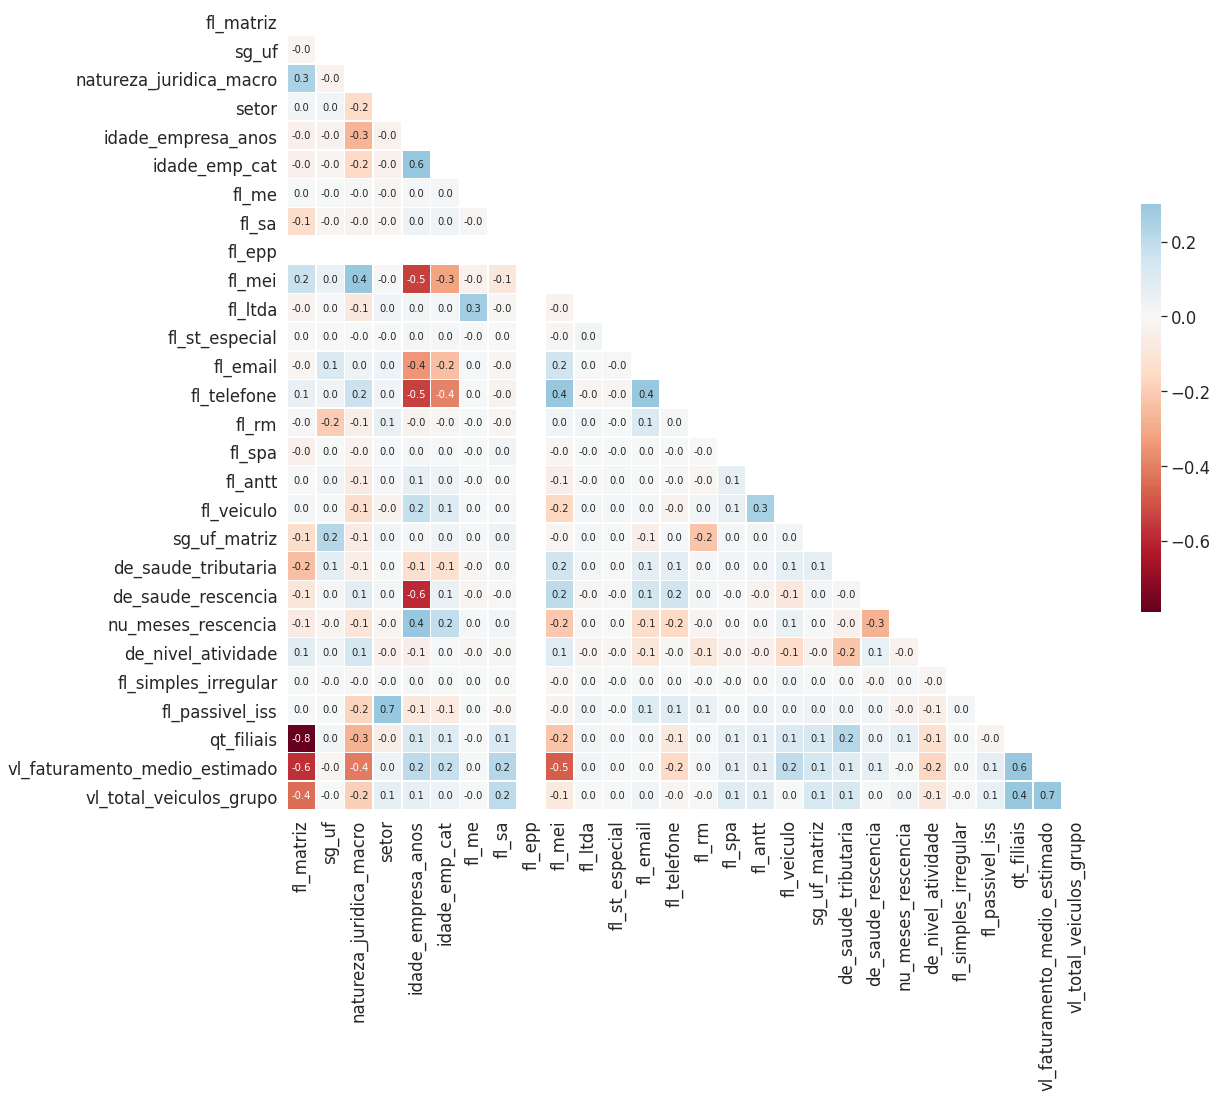

In [34]:
func.heatMap(mercado3)

Há colunas que possuem somente um valor. Isso não agrega nada para o modelo, por isso, vou exclui-las.

In [35]:
for col in mercado3.columns:
    if len(mercado3[col].value_counts()) == 1:
        mercado3.drop([col], axis = 1, inplace = True)

In [36]:
colunasSemImp = ['fl_me', "fl_st_especial", "fl_simples_irregular", 'fl_sa']
mercado3.drop([col], axis = 1, inplace = True)

In [37]:
mercado3.columns

Index(['fl_matriz', 'sg_uf', 'natureza_juridica_macro', 'setor',
       'idade_empresa_anos', 'idade_emp_cat', 'fl_me', 'fl_sa', 'fl_mei',
       'fl_ltda', 'fl_st_especial', 'fl_email', 'fl_telefone', 'fl_rm',
       'fl_spa', 'fl_antt', 'fl_veiculo', 'sg_uf_matriz',
       'de_saude_tributaria', 'de_saude_rescencia', 'nu_meses_rescencia',
       'de_nivel_atividade', 'fl_simples_irregular', 'fl_passivel_iss',
       'qt_filiais', 'vl_faturamento_medio_estimado'],
      dtype='object')

In [38]:
enc = OneHotEncoder(drop='first')

encodingVector = enc.fit_transform(dataInt).toarray()

encodingDF = pd.DataFrame(encodingVector, columns = enc.get_feature_names())

encodingDF['id'] = ID
dataFloat['id'] = ID

mercado3 = encodingDF.merge(dataFloat, on=['id'])

mercado3.set_index('id', inplace = True)

In [39]:
# pf1 = mercado3.merge(portifolio1.id, on = 'id', how = 'inner')
# pf2 = mercado3.merge(portifolio2, on = 'id', how = 'inner')
# pf3 = mercado3.merge(portifolio3, on = 'id', how = 'inner')

# listaID = []

# for Id in pf1.id:
#     listaID.append(Id)
    

# for Id in pf2.id:
#     listaID.append(Id)
    

# for Id in pf3.id:
#     listaID.append(Id)
    
# listaIDFlat = set(np.array(listaID))

# mercado3.set_index('id', inplace = True)

# mercado3.drop(index=list(listaIDFlat), inplace = True)

### * Testar outros parâmetros no modelo.
### * Tratar as variáveis de outra forma.
### * Crie mais um métrica de precision e recall
### * Procure sobre o gráfico Elbow.
### * Apresente melhor os resultados.

### Construindo o sistema de recomendação

In [42]:
n_neighbors = 5
radius = 15

model_knn = NearestNeighbors(n_neighbors = n_neighbors, n_jobs = -1, radius=radius)

model_knn.fit(mercado3)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=-1, n_neighbors=5, p=2, radius=1.0)

In [43]:
# salvando o modelo

# filename = './modeloFinal.sav'

# pickle.dump(model_knn, open(filename, 'wb'))

# Carregando o modelo
# model_knn = pickle.load(open(filename, 'rb'))

## Portifólio 1

In [44]:
pf1 = mercado3.merge(portifolio1.id, on = 'id', how = 'inner')

pf_train, pf_test = train_test_split(pf1,
                                     test_size=0.30, 
                                     random_state=42)

id_previsto = func.geraRecomendacao(pf_train.set_index('id'), mercado3, model_knn)

acerto = pd.Series(id_previsto).isin(pf_test.id).sum()
total = pf_test.shape[0]

func.metrica_acc(acerto, total)

0.66

## Portifólio 2

In [45]:
pf2 = mercado3.merge(portifolio2.id, on = 'id', how = 'inner')

pf_train, pf_test = train_test_split(pf2,
                                     test_size=0.30, 
                                     random_state=42)

id_previsto = func.geraRecomendacao(pf_train.set_index('id'), mercado3, model_knn)

acerto = pd.Series(id_previsto).isin(pf_test.id).sum()
total = pf_test.shape[0]

func.metrica_acc(acerto, total)

32.48

## Portifólio 3

In [46]:
pf3 = mercado3.merge(portifolio3.id, on = 'id', how = 'inner')

pf_train, pf_test = train_test_split(pf3,
                                     test_size=0.30, 
                                     random_state=42)

id_previsto = func.geraRecomendacao(pf_train.set_index('id'), mercado3, model_knn)

acerto = pd.Series(id_previsto).isin(pf_test.id).sum()
total = pf_test.shape[0]

func.metrica_acc(acerto, total)

32.88

### Avaliando o Modelo

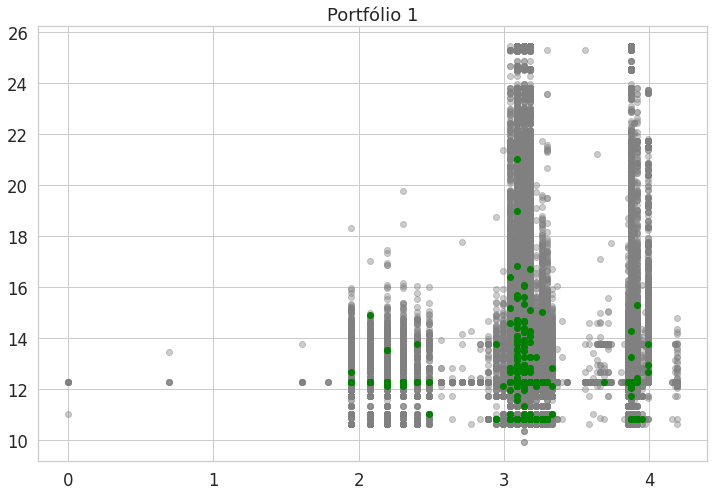

In [50]:
plt.figure(figsize=(12, 8))

plt.title("Portfólio 1")

plt.scatter(mercado3["nu_meses_rescencia"], 
            mercado3["vl_faturamento_medio_estimado"], 
            c='gray', 
            alpha=0.4)

plt.scatter(pf1["nu_meses_rescencia"], 
            pf1["vl_faturamento_medio_estimado"], 
            c='green', 
            alpha=1)

plt.show()

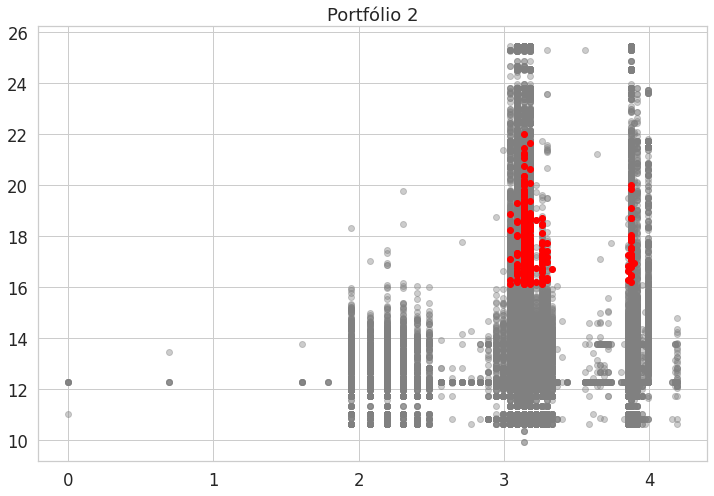

In [51]:
plt.figure(figsize=(12, 8))

plt.title("Portfólio 2")

plt.scatter(mercado3["nu_meses_rescencia"], 
            mercado3["vl_faturamento_medio_estimado"], 
            c='gray',
            alpha=0.4)

plt.scatter(pf2["nu_meses_rescencia"], 
            pf2["vl_faturamento_medio_estimado"], 
            c='red', 
            alpha=1)
plt.show()

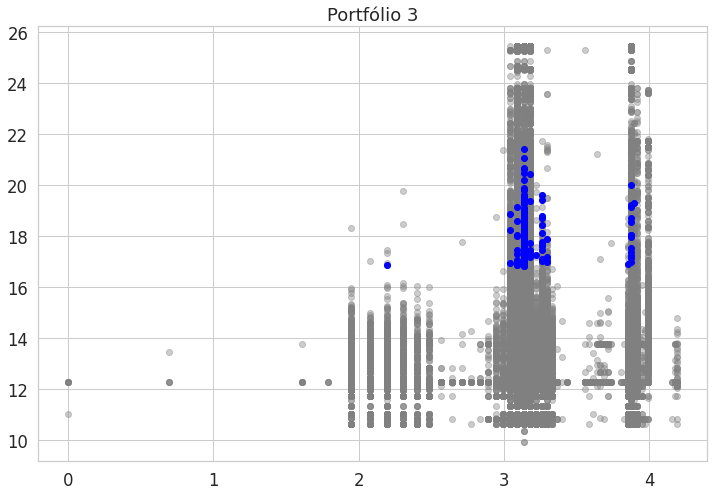

In [52]:
plt.figure(figsize=(12, 8))

plt.title("Portfólio 3")

plt.scatter(mercado3["nu_meses_rescencia"], 
            mercado3["vl_faturamento_medio_estimado"], 
            c='gray', 
            alpha=0.4)

plt.scatter(pf3["nu_meses_rescencia"], 
            pf3["vl_faturamento_medio_estimado"], 
            c='blue', 
            alpha=1)

plt.show()

In [ ]:
plt.figure(figsize=(12, 8))

sns.set(style='whitegrid',
        font_scale=1.5)

ax = sns.scatterplot(x = "nu_meses_rescencia",
                     y = "vl_faturamento_medio_estimado", 
                     hue = "Categoria", 
                     data = test,
                     palette = sns.color_palette("Set1", n_colors=3, desat=.5),
                     legend=False)

ax.set_ylabel('')
ax.set_xlabel('')

plt.show()

### Conclusão: 

## FIM